This notebook will be used to analyze the baroclinic tides over the CODAR region.

In [1]:
import datetime
import matplotlib.pylab as plt
import numpy as np
import scipy.io as sio
import netCDF4 as nc

from salishsea_tools.nowcast import (research_VENUS)
from salishsea_tools import viz_tools

%matplotlib inline

###Load Data

In [2]:
data =sio.loadmat('/ocean/nsoontie/MEOPAR/TidalEllipseData/CODAR/CODAR_region_baroclinic_20141126_20150426.mat')
datastruc = data['datastruc']
lats = datastruc['lats'][0,0]
lons = datastruc['lons'][0,0]

grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

In [3]:
#Isolate M2 phase/major axis (at surface)
M2 = datastruc['M2']
dep=0

major = M2[0,0]['major'][0,0][:,:,dep]
major = np.ma.masked_invalid(major)

phase = M2[0,0]['phase'][0,0][:,:,dep]
phase = np.ma.masked_invalid(phase)

(48.8, 49.3)

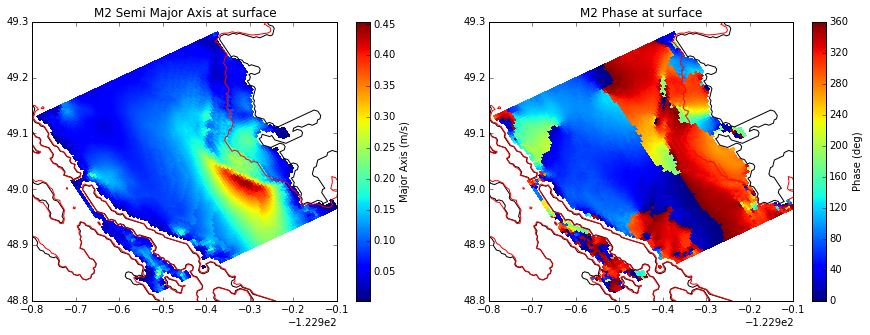

In [4]:
fig, axs = plt.subplots(1,2,figsize= (15,5))
lonax = [-123.7,-123]
latax= [48.8,49.3]

#major
ax=axs[0]
mesh  = ax.pcolormesh(lons, lats, major)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Major Axis (m/s)')
ax.set_title('M2 Semi Major Axis at surface')
viz_tools.plot_coastline(ax, grid, coords = 'map')
viz_tools.plot_coastline(ax, grid, coords = 'map', isobath = 5, color = 'red')
ax.set_xlim(lonax)
ax.set_ylim(latax)

#phase
ax=axs[1]
#modify phase for continuty
mesh  = ax.pcolormesh(lons, lats, phase)
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('Phase (deg)')
ax.set_title('M2 Phase at surface')
viz_tools.plot_coastline(ax, grid, coords = 'map')
viz_tools.plot_coastline(ax, grid, coords = 'map', isobath = 5, color = 'red')
ax.set_xlim(lonax)
ax.set_ylim(latax)

Need to work on phase but major axis is neat